# Econ 320 – Homework 2  
## Questions 1–3: Medicare Advantage Markets (2014–2019)

GitHub repository: https://github.com/CarsonSleeman/Homework-2-


In [ ]:
import os
import pandas as pd

# ----------------------------
# 1) LANDSCAPE (2014–2019)
# ----------------------------
landscape_path = "../ma-data/ma/landscape/Extracted Data"

files = sorted([
    f for f in os.listdir(landscape_path)
    if f.endswith(".csv")
    and f.startswith(tuple(str(y) for y in range(2014, 2020)))
    and "LandscapeSource file MA" in f
    and ("AtoM" in f or "NtoW" in f)
    and "Sanction" not in f
])

def read_landscape_file(path, year):
    raw = pd.read_csv(path, encoding="latin1", header=None, low_memory=False)
    header_idx = raw.index[raw.iloc[:, 0].astype(str).str.strip().eq("State")][0]
    df = raw.iloc[header_idx:].copy()
    df.columns = df.iloc[0].astype(str).str.strip()
    df = df.iloc[1:].copy()
    df["year"] = year
    df = df.drop(columns=["nan"], errors="ignore")
    return df

landscape_dfs = []
for f in files:
    year = int(f[:4])
    landscape_dfs.append(read_landscape_file(os.path.join(landscape_path, f), year))

landscape = pd.concat(landscape_dfs, ignore_index=True, sort=False)

# Clean ID types
landscape["Contract ID"] = landscape["Contract ID"].astype(str).str.strip()

# ----------------------------
# 2) SERVICE AREA (Jan files, 2014–2019)
# ----------------------------
sa_path = "../ma-data/ma/service-area/Extracted Data"

sa_files = sorted([
    f for f in os.listdir(sa_path)
    if f.startswith("MA_Cnty_SA_")
    and f.endswith("_01.csv")
    and any(f"_{y}_" in f for y in range(2014, 2020))
])

sa_dfs = []
for f in sa_files:
    df = pd.read_csv(os.path.join(sa_path, f), low_memory=False)
    df["year"] = int(f.split("_")[3])  # MA_Cnty_SA_YYYY_MM.csv
    df["Contract ID"] = df["Contract ID"].astype(str).str.strip()
    sa_dfs.append(df)

service_area = pd.concat(sa_dfs, ignore_index=True)

# ----------------------------
# 3) MERGE (Contract ID + year), for Q1 counts
# ----------------------------
merged = landscape.merge(
    service_area[["Contract ID", "FIPS", "year"]],
    on=["Contract ID", "year"],
    how="inner"
)

print("landscape:", landscape.shape)
print("service_area:", service_area.shape)
print("merged:", merged.shape)

merged.head()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


QUESTION 1

In [ ]:
import os
os.listdir("../ma-data")



In [ ]:
os.listdir("../ma-data/ma")


In [ ]:
import os
os.listdir("../ma-data/ma/landscape")[:30]


In [ ]:
os.listdir("../ma-data/ma/service-area")[:30]


In [ ]:
os.listdir("../ma-data/ma/landscape/Extracted Data")


In [ ]:
os.listdir("../ma-data/ma/service-area/Extracted Data")


In [ ]:
os.listdir("../ma-data/ma/landscape/Extracted Data")


In [ ]:
os.listdir("../ma-data/ma/service-area/Extracted Data")


In [ ]:
import os
import pandas as pd

landscape_path = "../ma-data/ma/landscape/Extracted Data"

files = [
    f for f in os.listdir(landscape_path)
    if f.endswith(".csv")
    and "LandscapeSource file MA" in f          # only source files
    and any(str(y) in f for y in range(2014, 2020))
    and "Sanction" not in f
]
files

In [ ]:
landscape_dfs = []

for f in files:
    df = pd.read_csv(
        os.path.join(landscape_path, f),
        encoding="latin1",      # key fix
        low_memory=False
    )
    df["year"] = int([y for y in range(2014, 2020) if str(y) in f][0])
    landscape_dfs.append(df)

landscape = pd.concat(landscape_dfs, ignore_index=True)
landscape.head()


In [ ]:
landscape.columns


In [ ]:
import os
import pandas as pd

def read_landscape_file(path, year):
    raw = pd.read_csv(path, encoding="latin1", header=None, low_memory=False)

    # Find the header row where the first column equals "State"
    header_idx = raw.index[raw.iloc[:, 0].astype(str).str.strip().eq("State")][0]

    df = raw.iloc[header_idx:].copy()
    df.columns = df.iloc[0].astype(str).str.strip()
    df = df.iloc[1:].copy()

    df["year"] = year
    return df

landscape_path = "../ma-data/ma/landscape/Extracted Data"

# IMPORTANT: make sure files is your correct list of 2014–2019 LandscapeSource file MA AtoM/NtoW csvs
landscape_dfs = []
for f in files:
    year = int(f[:4])
    df = read_landscape_file(os.path.join(landscape_path, f), year)
    landscape_dfs.append(df)

landscape = pd.concat(landscape_dfs, ignore_index=True, sort=False)

print(landscape.shape)
print(landscape.columns.tolist()[:25])
landscape.head()



In [ ]:
landscape_dfs = []

for f in files:
    raw = pd.read_csv(
        os.path.join(landscape_path, f),
        encoding="latin1",
        header=None,
        skiprows=4,
        low_memory=False
    )

    # Use first row as header
    header = raw.iloc[0].astype(str).str.strip()

    df = raw.iloc[1:].copy()
    df.columns = header

    # Drop completely empty column names (like "nan")
    df = df.loc[:, ~df.columns.isna()]
    df = df.loc[:, df.columns.astype(str) != "nan"]


    # Make column names unique (adds .1, .2, etc if duplicated)
    df.columns = pd.Index(df.columns).astype(str)
    df = df.loc[:, ~df.columns.duplicated()]

    df["year"] = int(f[:4])
    landscape_dfs.append(df)

landscape = pd.concat(landscape_dfs, ignore_index=True, sort=False)

print(landscape.shape)
print(landscape.columns.tolist()[:30])
landscape.head()



In [ ]:
landscape[["Contract ID", "Plan ID", "State", "County", "year"]].head()


In [ ]:
# drop junk columns
landscape = landscape.drop(columns=["nan"], errors="ignore")

# standardize IDs
landscape["Contract ID"] = landscape["Contract ID"].astype(str).str.strip()
landscape["Plan ID"] = landscape["Plan ID"].astype(str).str.strip().str.zfill(3)

# create full plan identifier used in service-area files
landscape["plan_id"] = landscape["Contract ID"] + "-" + landscape["Plan ID"]

landscape[["plan_id", "Contract ID", "Plan ID", "year"]].head()


In [ ]:
import os
import pandas as pd

sa_path = "../ma-data/ma/service-area/Extracted Data"

sa_files = sorted([
    f for f in os.listdir(sa_path)
    if f.startswith("MA_Cnty_SA_")
    and f.endswith("_01.csv")
    and any(f"_{y}_" in f for y in range(2014, 2020))
])

print(*sa_files, sep="\n")


In [ ]:
sa_dfs = []
for f in sa_files:
    df = pd.read_csv(os.path.join(sa_path, f), low_memory=False)
    df["year"] = int(f.split("_")[3])  # MA_Cnty_SA_YYYY_MM.csv
    sa_dfs.append(df)

service_area = pd.concat(sa_dfs, ignore_index=True)

service_area.columns


In [ ]:
plan_col = "Contract ID"
fips_col = "FIPS"

service_area[[plan_col, fips_col, "year"]].head()



In [ ]:
import os
import pandas as pd

landscape_path = "../ma-data/ma/landscape/Extracted Data"
sa_path = "../ma-data/ma/service-area/Extracted Data"


In [ ]:
year = 2018

files_2018 = sorted([
    f for f in os.listdir(landscape_path)
    if f.startswith(str(year))
    and f.endswith(".csv")
    and "LandscapeSource file MA" in f
    and ("AtoM" in f or "NtoW" in f)
    and "Sanction" not in f
])

files_2018


In [ ]:
def read_landscape_file(path, year):
    raw = pd.read_csv(path, encoding="latin1", header=None, low_memory=False)
    header_idx = raw.index[raw.iloc[:, 0].astype(str).str.strip().eq("State")][0]
    df = raw.iloc[header_idx:].copy()
    df.columns = df.iloc[0].astype(str).str.strip()
    df = df.iloc[1:].copy()
    df["year"] = year
    return df


In [ ]:
landscape_2018 = pd.concat(
    [read_landscape_file(os.path.join(landscape_path, f), 2018) for f in files_2018],
    ignore_index=True,
    sort=False
)

landscape_2018 = landscape_2018.drop(columns=["nan"], errors="ignore")
landscape_2018["Contract ID"] = landscape_2018["Contract ID"].astype(str).str.strip()

landscape_2018[["Contract ID", "Plan ID", "State", "County", "year"]].head()


In [ ]:
sa_file_2018 = "MA_Cnty_SA_2018_01.csv"
service_area_2018 = pd.read_csv(os.path.join(sa_path, sa_file_2018), low_memory=False)

service_area_2018["year"] = 2018
service_area_2018["Contract ID"] = service_area_2018["Contract ID"].astype(str).str.strip()

service_area_2018[["Contract ID", "FIPS", "County", "State", "year"]].head()


In [ ]:
merged_2018 = landscape_2018.merge(
    service_area_2018[["Contract ID", "FIPS", "year"]],
    on=["Contract ID", "year"],
    how="inner"
)

county_counts_2018 = (
    merged_2018.groupby(["year", "FIPS"])["Contract ID"]
    .nunique()
    .reset_index(name="num_plans")
)

county_counts_2018.describe()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
county_counts_2018.boxplot(column="num_plans", by="year")
plt.suptitle("")
plt.title("MA Contracts per County (2018)")
plt.ylabel("Number of Contracts")
plt.show()


In [ ]:
def county_counts_for_year_light(y):
    year_files = sorted([
        f for f in os.listdir(landscape_path)
        if f.startswith(str(y))
        and f.endswith(".csv")
        and "LandscapeSource file MA" in f
        and ("AtoM" in f or "NtoW" in f)
        and "Sanction" not in f
    ])

    # 1. Load the FULL landscape data (not just Contract IDs) to filter
    landscape_list = []
    for f in year_files:
        raw = pd.read_csv(os.path.join(landscape_path, f), encoding="latin1", header=None, low_memory=False)
        header_idx = raw.index[raw.iloc[:, 0].astype(str).str.strip().eq("State")][0]
        df = raw.iloc[header_idx:].copy()
        df.columns = df.iloc[0].astype(str).str.strip()
        df = df.iloc[1:].copy()
        landscape_list.append(df)
    
    land_y = pd.concat(landscape_list, ignore_index=True)
    
    # 2. APPLY FILTERS (The Crucial Step)
    # Convert Plan ID to numeric for filtering
    land_y['Plan ID'] = pd.to_numeric(land_y['Plan ID'], errors='coerce')
    
    # Filter 1: Remove 800-series plans (Employer plans)
    land_y = land_y[(land_y['Plan ID'] < 800) | (land_y['Plan ID'] > 899)]
    
    # Filter 2: Remove SNPs
    # Most files have a column 'SNP' or 'Special Needs Plan'. If not, we check 'Plan Name'
    if 'SNP' in land_y.columns:
        land_y = land_y[land_y['SNP'].astype(str).str.upper() == 'NO']
    
    # Filter 3: Remove Part-D only (Must offer Part C)
    # The prompt says "plans that do not offer Part C benefits". 
    # Usually, if Monthly Premium is "Part D only", we drop it.
    # A safer way is checking 'Type of Medicare Health Plan'
    land_y = land_y[~land_y['Type of Medicare Health Plan'].astype(str).str.contains("Prescription Drug Only", na=False)]

    # 3. Standardize and Merge
    land_y["Contract ID"] = land_y["Contract ID"].astype(str).str.strip()
    land_y["year"] = y
    
    # Load service area
    sa_file = f"MA_Cnty_SA_{y}_01.csv"
    sa_y = pd.read_csv(os.path.join(sa_path, sa_file), low_memory=False)
    sa_y["Contract ID"] = sa_y["Contract ID"].astype(str).str.strip()

    # Merge and count unique Plan-Contract combinations per county (FIPS)
    merged = land_y.merge(sa_y[["Contract ID", "FIPS"]], on="Contract ID", how="inner")
    
    # We count unique (Contract ID + Plan ID) per FIPS
    counts_y = (
        merged.groupby(["FIPS"])
        .size() # This counts the specific plan offerings per county
        .reset_index(name="num_plans")
    )
    counts_y["year"] = y
    return counts_y


In [ ]:
all_counts = []
for y in range(2014, 2020):
    print("Working on", y)
    all_counts.append(county_counts_for_year(y))

county_counts = pd.concat(all_counts, ignore_index=True)
county_counts.head(), county_counts.shape


In [ ]:
import os
import pandas as pd

# paths relative to notebooks/
landscape_path = "../ma-data/ma/landscape/Extracted Data"
sa_path = "../ma-data/ma/service-area/Extracted Data"

# sanity check
print(len(os.listdir(landscape_path)), "landscape files")
print(len(os.listdir(sa_path)), "service area files")


In [ ]:
def contracts_from_landscape_file(path):
    raw = pd.read_csv(path, encoding="latin1", header=None, low_memory=False)

    header_idx = raw.index[
        raw.iloc[:, 0].astype(str).str.strip().eq("State")
    ][0]

    df = raw.iloc[header_idx:].copy()
    df.columns = df.iloc[0].astype(str).str.strip()

    return df["Contract ID"].astype(str).str.strip()


In [ ]:
def county_counts_for_year_light(y):
    year_files = sorted([
        f for f in os.listdir(landscape_path)
        if f.startswith(str(y))
        and f.endswith(".csv")
        and "LandscapeSource file MA" in f
        and ("AtoM" in f or "NtoW" in f)
        and "Sanction" not in f
    ])

    # Load and clean landscape
    temp_land = []
    for f in year_files:
        # Use your established reading logic
        raw = pd.read_csv(os.path.join(landscape_path, f), encoding="latin1", header=None, low_memory=False)
        header_idx = raw.index[raw.iloc[:, 0].astype(str).str.strip().eq("State")][0]
        df = raw.iloc[header_idx:].copy()
        df.columns = df.iloc[0].astype(str).str.strip()
        df = df.iloc[1:].copy()
        temp_land.append(df)
    
    land_y = pd.concat(temp_land, ignore_index=True)

    # --- MANDATORY FILTERS FOR HW2 ---
    # 1. Drop 800-series (Employer Plans)
    land_y['Plan ID'] = pd.to_numeric(land_y['Plan ID'], errors='coerce')
    land_y = land_y[(land_y['Plan ID'] < 800) | (land_y['Plan ID'] > 899)]

    # 2. Drop SNPs (Special Needs Plans)
    # Most years use the 'SNP' column. If not found, we look for 'Special Needs Plan'
    snp_col = [c for c in land_y.columns if 'SNP' in c.upper() or 'SPECIAL NEEDS' in c.upper()]
    if snp_col:
        land_y = land_y[land_y[snp_col[0]].astype(str).str.upper().str.contains('NO', na=False)]

    # 3. Drop Prescription Drug Only (Must offer Part C)
    land_y = land_y[~land_y['Type of Medicare Health Plan'].astype(str).str.contains("Prescription Drug Only", na=False)]

    # Standardize Contract ID
    land_y["Contract ID"] = land_y["Contract ID"].astype(str).str.strip()
    land_y["year"] = y

    # Load service area
    sa_file = f"MA_Cnty_SA_{y}_01.csv"
    sa_y = pd.read_csv(os.path.join(sa_path, sa_file), low_memory=False)
    sa_y["Contract ID"] = sa_y["Contract ID"].astype(str).str.strip()

    # Merge
    merged = land_y.merge(sa_y[["Contract ID", "FIPS"]], on="Contract ID", how="inner")

    # Count unique plans (Contract + Plan ID) per county
    return (
        merged.groupby(["FIPS"])
        .size()
        .reset_index(name="num_plans")
        .assign(year=y)
    )

# --- THE CORRECTED LOOP ---
all_counts = []
for y in range(2014, 2020):
    print("Working on", y)
    # Make sure this name matches the function name above exactly!
    counts_y = county_counts_for_year_light(y)
    all_counts.append(counts_y)

county_counts = pd.concat(all_counts, ignore_index=True)

In [ ]:
all_counts = []

for y in range(2014, 2020):
    print("Working on", y)
    counts_y = county_counts_for_year_light(y)
    all_counts.append(counts_y)

county_counts = pd.concat(all_counts, ignore_index=True)
county_counts.head(), county_counts.shape


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
county_counts.boxplot(column="num_plans", by="year")
plt.suptitle("")
plt.title("Distribution of Medicare Advantage Plan Counts by County (2014–2019)")
plt.xlabel("Year")
plt.ylabel("Number of Plans (unique contracts)")
plt.show()


In [ ]:
summary = county_counts.groupby("year")["num_plans"].describe()
summary


Plan availability fell from 2014 to 2017 and then rose again through 2019. While many counties have plenty of plans, some have very few, meaning choice is not evenly distributed.

In [ ]:
import os

pay_path = "../ma-data/ma/cms-payment"
os.listdir(pay_path)


In [ ]:
import os

print("2014 files:")
print(os.listdir("../ma-data/ma/cms-payment/2014"))

print("\n2018 files:")
print(os.listdir("../ma-data/ma/cms-payment/2018"))


In [ ]:
import pandas as pd
import os

pay_dfs = []

for year in [2014, 2018]:
    year_path = f"../ma-data/ma/cms-payment/{year}"
    files = [f for f in os.listdir(year_path) if f.endswith(".csv")]

    df = pd.read_csv(os.path.join(year_path, files[0]), low_memory=False)
    df["year"] = year
    pay_dfs.append(df)

payments = pd.concat(pay_dfs, ignore_index=True)
payments.columns


In [ ]:
import os

print("2014 contents:")
print(os.listdir("../ma-data/ma/cms-payment/2014"))

print("\n2018 contents:")
print(os.listdir("../ma-data/ma/cms-payment/2018"))


In [ ]:
import pandas as pd

p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx"
)
p2014["year"] = 2014

p2018 = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx"
)
p2018["year"] = 2018

payments = pd.concat([p2014, p2018], ignore_index=True)
payments.columns


In [ ]:
!pip install openpyxl


In [ ]:
payments.columns


In [ ]:
payments = payments.rename(columns={
    payments.columns[0]: "pmpm_payment"
})


In [ ]:
payments = payments[
    (payments["pmpm_payment"] > 0) & (payments["pmpm_payment"] < 2000)
]


In [ ]:
payments["pmpm_payment"] = (
    payments["pmpm_payment"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

payments["pmpm_payment"] = pd.to_numeric(
    payments["pmpm_payment"], errors="coerce"
)


In [ ]:
payments.groupby("year")["pmpm_payment"].describe()


In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
payments.loc[payments.year == 2014, "pmpm_payment"].hist(bins=40)
plt.title("Plan Payment Distribution – 2014")
plt.xlabel("PMPM Payment ($)")
plt.ylabel("Number of Plans")

plt.subplot(1,2,2)
payments.loc[payments.year == 2018, "pmpm_payment"].hist(bins=40)
plt.title("Plan Payment Distribution – 2018")
plt.xlabel("PMPM Payment ($)")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
payments.groupby("year")["pmpm_payment"].count()


In [ ]:
import pandas as pd

xls_2014 = pd.ExcelFile("../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx")
xls_2014.sheet_names


In [ ]:
xls_2018 = pd.ExcelFile("../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx")
xls_2018.sheet_names


In [ ]:
p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    sheet_name="Sheet2"
)
p2014["year"] = 2014
p2014.head()



In [ ]:
p2018 = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx",
    sheet_name="Sheet1"
)
p2018["year"] = 2018
p2018.head()

In [ ]:
p2014_raw = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    sheet_name="Sheet2",
    header=None
)

p2014_raw.head(10)


In [ ]:
p2018_raw = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx",
    sheet_name="Sheet1",
    header=None
)

p2018_raw.head(10)

In [ ]:
p2014_raw.iloc[:15, :15]


In [ ]:
p2018_raw.iloc[:15, :15]


In [ ]:
import pandas as pd

xls = pd.ExcelFile("../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx")
xls.sheet_names


In [ ]:
for s in xls.sheet_names:
    df = pd.read_excel(
        "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
        sheet_name=s,
        header=None
    )
    print(s, df.applymap(lambda x: isinstance(x, (int, float))).sum().sum())

In [ ]:
p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    sheet_name="result.srx"
)

p2014.head()

In [ ]:
p2014.columns


In [ ]:
p2014 = p2014.rename(columns={
    "Plan Level Average Per Member Per Month (PM/PM) Payment for 2014": "pmpm_payment"
})

In [ ]:
p2014 = p2014[["pmpm_payment"]]
p2014["year"] = 2014

In [ ]:
p2014["pmpm_payment"] = pd.to_numeric(p2014["pmpm_payment"], errors="coerce")


In [ ]:
p2014["pmpm_payment"].describe()


In [ ]:
p2014_raw.iloc[:15, :8]


In [ ]:
p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    sheet_name="result.srx"
)


In [ ]:
p2014 = p2014.rename(columns={
    "Average A/B PM/PM\nPayment": "pmpm_payment"
})

In [ ]:
p2014.columns

In [ ]:
p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    sheet_name="result.srx",
    skiprows=1
)

In [ ]:
p2014.columns

In [ ]:
p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    sheet_name="result.srx",
    header=2
)

In [ ]:
p2014.columns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

p2014 = pd.read_excel(
    "../ma-data/ma/cms-payment/2014/2014PartCPlan Level.xlsx",
    skiprows=2
)

p2014 = p2014[[
    "Contract Number",
    "Average A/B PM/PM\nPayment",
    "Average Rebate PM/PM\nPayment"
]].copy()

p2014.columns = ["contract", "ab_pmpm", "rebate_pmpm"]
p2014["year"] = 2014

In [ ]:
for df in [p2014, p2018]:
    df["bid"] = df["ab_pmpm"] - df["rebate_pmpm"]

In [ ]:
print(p2014.columns.tolist())


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(p2014["bid"].dropna(), bins=40)
plt.title("Plan Bid Distribution (2014)")
plt.xlabel("Monthly Bid ($)")
plt.ylabel("Number of Plans")

plt.subplot(1,2,2)
plt.hist(p2018["bid"].dropna(), bins=40)
plt.title("Plan Bid Distribution (2018)")
plt.xlabel("Monthly Bid ($)")

plt.tight_layout()
plt.show()


In [ ]:
print(p2018.columns.tolist())


In [ ]:
p2018 = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx",
    skiprows=2
)

p2018 = p2018[[
    "Contract Number",
    "Average A/B PM/PM\nPayment",
    "Average Rebate PM/PM\nPayment"
]].copy()

p2018.columns = ["contract", "ab_pmpm", "rebate_pmpm"]
p2018["year"] = 2018

In [ ]:
print(p2018.columns.tolist())


In [ ]:
p2018_raw = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx",
    header=None
)

p2018_raw.head(10)


In [ ]:
p2018_raw = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx",
    header=None
)

In [ ]:
header_row = p2018_raw[p2018_raw.apply(
    lambda row: row.astype(str).str.contains("Contract Number").any(),
    axis=1
)].index[0]

header_row

In [ ]:
header_row = p2018_raw[p2018_raw.apply(
    lambda row: row.astype(str).str.contains("Contract", case=False).any(),
    axis=1
)].index[0]

header_row

In [ ]:
xls = pd.ExcelFile("../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx")
xls.sheet_names

In [ ]:
p2018 = pd.read_excel(
    "../ma-data/ma/cms-payment/2018/2018PartCPlanLevel.xlsx",
    sheet_name="result.srx",
    skiprows=2
)

In [ ]:
p2018.columns.tolist()


In [ ]:
p2018 = p2018[[
    "Contract Number",
    "Average A/B PM/PM Payment",
    "Average Rebate PM/PM Payment"
]].copy()

p2018.columns = ["contract", "ab_pmpm", "rebate_pmpm"]
p2018["year"] = 2018

In [ ]:
p2018.head()


In [ ]:
p2018["bid"] = p2018["ab_pmpm"] - p2018["rebate_pmpm"]


In [ ]:
p2018["bid"].describe()


QUESTION 2

NameError: name 'p2014' is not defined

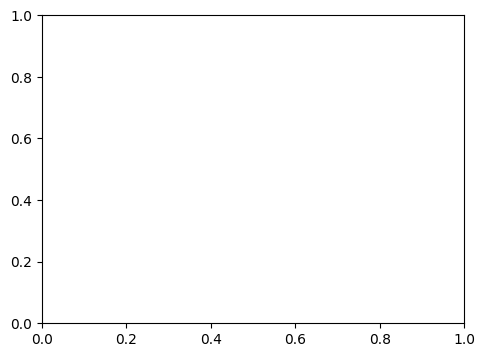

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(p2014["bid"].dropna(), bins=40)
plt.title("Plan Bid Distribution (2014)")
plt.xlabel("Monthly Bid ($)")
plt.ylabel("Number of Plans")

plt.subplot(1,2,2)
plt.hist(p2018["bid"].dropna(), bins=40)
plt.title("Plan Bid Distribution (2018)")
plt.xlabel("Monthly Bid ($)")

plt.tight_layout()
plt.show()

Interpretation: The histograms show that in 2014, Medicare Advantage plan bids were more tightly clustered around a lower central value. By 2018, the distribution shifts to the right and becomes more spread out, indicating higher average bids and greater variation across plans. This suggests that plan costs increased over time and that differences between plans became larger.